In [3]:
from pyamg.gallery.elasticity import linear_elasticity
from plot_utils import *
from mat_utils import PetscAMGMechanics
from petsc4py import PETSc


A, B = linear_elasticity(grid=(100, 100), spacing=(1, 2), E=1e14, nu=0.01, format='csr')

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


Solve  took: 0.05
True residual decrease: 2.141232189632237e-09
PETSc Converged Reason: 2


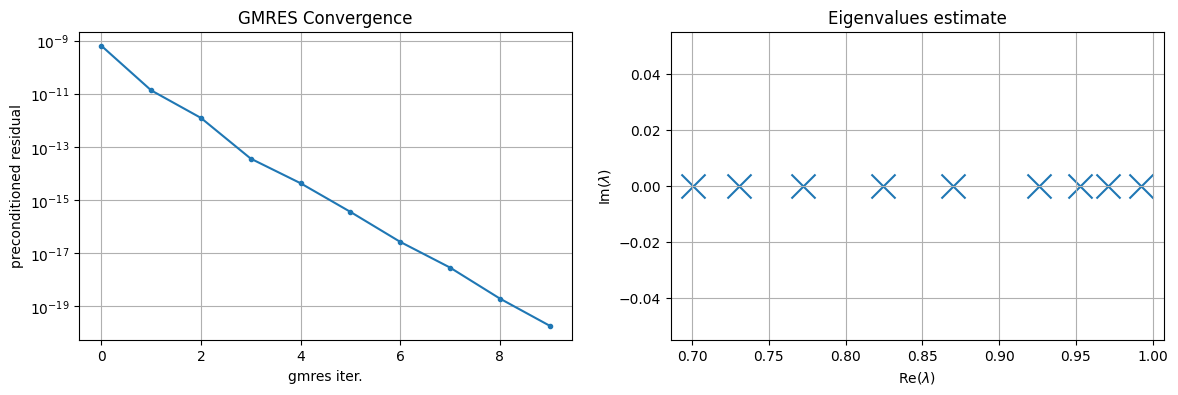

In [72]:
prec = PetscAMGMechanics(dim=2, mat=A)
solve_petsc(A, prec)

Solve  took: 0.08
True residual decrease: 4.6086230921355183e-10
PETSc Converged Reason: 2


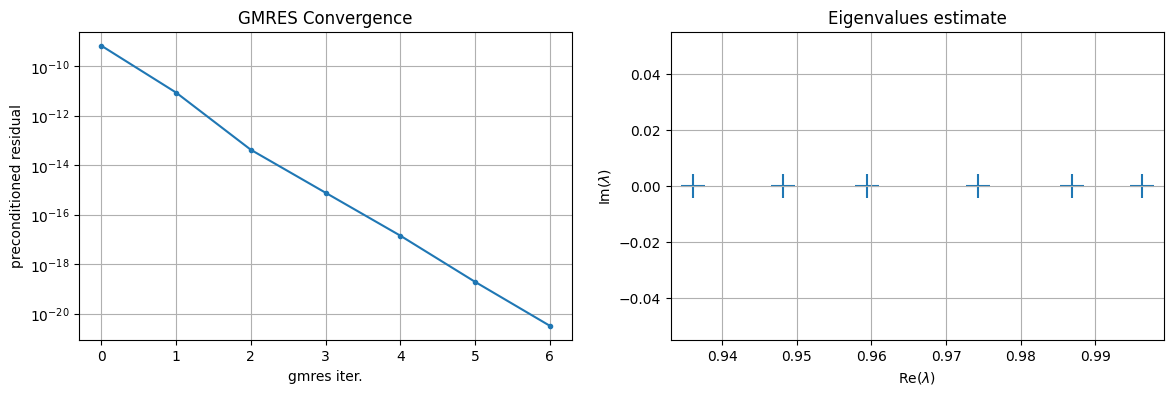

In [74]:
prec = PetscAMGMechanics(dim=2, mat=A, null_space=B.T)
solve_petsc(A, prec)

In [2]:
prec.pc.view()

PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization FULL
    Preconditioner for the Schur complement formed from user provided matrix
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_5_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using NONE norm type for convergence test
      PC Object: (fieldsplit_5_) 1 MPI process
        type: gamg
          type is MULTIPLICATIVE, levels=2 cycles=v
            Cycles per PCApply=1
            Using externally compute Galerkin coarse grid matrices
            GAMG specific options
              Threshold for dropping small values in graph on each level =         -1.         -1.        
              Threshold scaling factor for each level not specified = 1.

: 

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


Solve  took: 1.53
True residual decrease: 4.221505726369418e-11
PETSc Converged Reason: 2


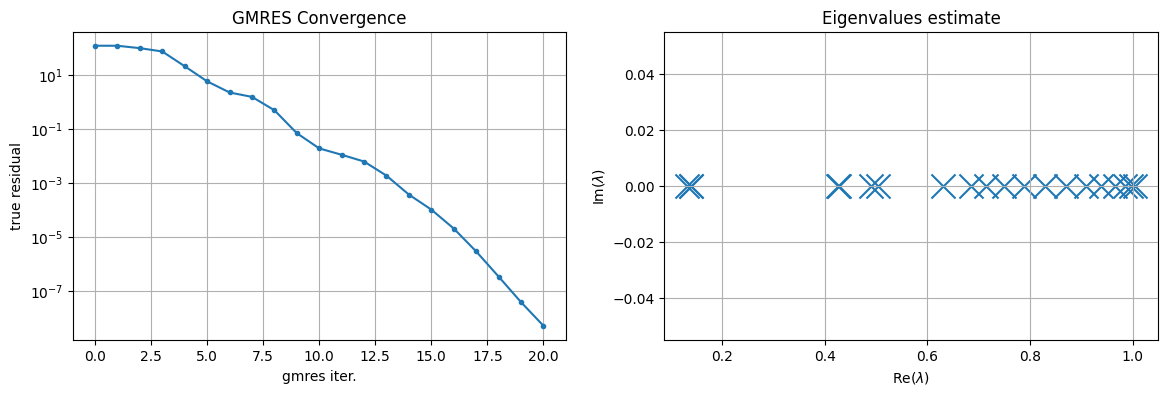

In [2]:
from mat_utils import *
from plot_utils import solve_petsc


Jmech = scipy.sparse.load_npz("fpm/J15.npz")
nns = np.load("fpm/near_null_space.npy")
sep = 14502
idx = np.arange(Jmech.shape[0], dtype=np.int32)
idx_1 = idx[:sep]
idx_5 = idx[sep:]
J11 = Jmech[:sep, :sep]
J55 = Jmech[sep:, sep:]
J15 = Jmech[:sep, sep:]
J51 = Jmech[sep:, :sep]

petsc_is_1 = PETSc.IS().createGeneral(idx_1)
petsc_is_5 = PETSc.IS().createGeneral(idx_5)


prec = PetscCustomPC(
    {
        "pc_type": "fieldsplit",
        "pc_fieldsplit_schur_fact_type": "full",
        "pc_fieldsplit_type": "schur",
        "fieldsplit_ksp_type": "preonly",
        "fieldsplit_pc_type": "gamg",
        'fieldsplit_mg_levels_pc_type': 'ilu',
    },
    block_size=3,
    null_space=nns,
)

prec.pc.setFieldSplitIS(
    ("5", petsc_is_5),
    ("1", petsc_is_1),
)
S11 = (J11 - J15 @ inv_block_diag(J55, nd=3, lump=True) @ J51).tocsr()
S11 = PETSc.Mat().createAIJ(
    size=S11.shape,
    csr=(S11.indptr, S11.indices, S11.data),
    bsize=3,
)
prec.pc.setFieldSplitSchurPreType(petsc4py.PETSc.PC.FieldSplitSchurPreType.USER, S11)
prec.set_operator(Jmech)
prec.pc.setUp()
# prec.pc.view()

solve_petsc(Jmech, prec, pc_side='right')


In [1]:
prec = PetscCustomPC(
    {
        'pc_type': 'gamg',
        'mg_levels_ksp_type': 'richardson',
        'mg_levels_ksp_max_iter': 1,
        'mg_levels_pc_type': 'ilu',
        # 'mg_levels_pc_type': 'fieldsplit',
        # "mg_levels_fieldsplit_type": "additive",
        # 'mg_levels_fieldsplit_ksp_type': 'preonly',
        # "mg_levels_fieldsplit_schur_fact_type": "full",
    },
    block_size=3,
    null_space=nns,
)

S11 = (J11 - J15 @ inv_block_diag(J55, nd=3, lump=True) @ J51).tocsr()
S11 = PETSc.Mat().createAIJ(
    size=S11.shape,
    csr=(S11.indptr, S11.indices, S11.data),
    bsize=3,
)
prec.pc.setFieldSplitSchurPreType(petsc4py.PETSc.PC.FieldSplitSchurPreType.USER, S11)
prec.pc.setFieldSplitIS(
    ("5", petsc_is_5),
    ("1", petsc_is_1),
)
prec.set_operator(Jmech)
prec.pc.setUp()
prec.pc.view()



NameError: name 'PetscCustomPC' is not defined

Solve  took: 0.93
True residual decrease: 4.898080098226855e-11
PETSc Converged Reason: 2


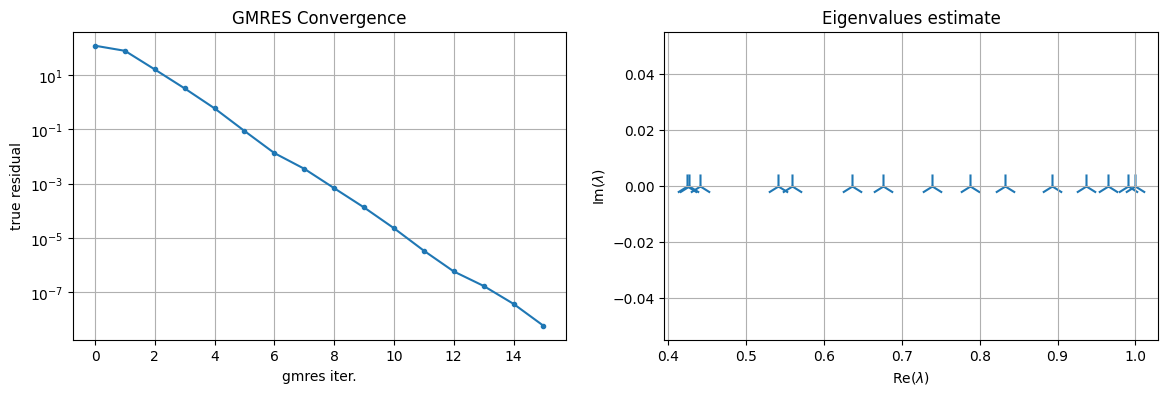

In [18]:
solve_petsc(Jmech, prec, pc_side='right')

In [5]:
prec.pc.getMGSmoother(2).view()

KSP Object: (mg_levels_2_) 1 MPI process
  type: richardson
    damping factor=1.
  maximum iterations=2, nonzero initial guess
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using NONE norm type for convergence test
PC Object: (mg_levels_2_) 1 MPI process
  type: fieldsplit
    FieldSplit with MULTIPLICATIVE composition: total splits = 3, blocksize = 3
    Solver info for each split is in the following KSP objects:
  Split number 0 Fields  0
  KSP Object: (mg_levels_2_fieldsplit_0_) 1 MPI process
    type: preonly
    maximum iterations=10000, initial guess is zero
    tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
    left preconditioning
    using NONE norm type for convergence test
  PC Object: (mg_levels_2_fieldsplit_0_) 1 MPI process
    type: ilu
      out-of-place factorization
      0 levels of fill
      tolerance for zero pivot 2.22045e-14
      matrix ordering: natural
      factor fill ratio given 1., needed 1.    